In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 문제 1) 데이터셋 로딩 및 초기 탐색

In [2]:
# 1-1 시본에서 제공하는 펭귄 데이터셋 로드하기
penguins = sns.load_dataset('penguins')

In [3]:
# 1-2 첫 5행 데이터 확인
penguins.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [4]:
# 1-3 데이터의 기본 정보 확인
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
# 1-4 데이터셋의 크기 확인
penguins.shape

(344, 7)

In [6]:
# 1-5 기본통계량 확인
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


### 문제 2) 데이터 전처리 및 품질 관리

In [7]:
# 2-1 컬럼별로 결측치 개수 확인
penguins.isnull().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11


In [8]:
# 2-2 결측치가 있는 행의 갯수 확인
penguins.isnull().any(axis=1).sum()

np.int64(11)

In [9]:
# 2-3 수치형 변수에 대한 이상치 확인 (IQR 방법)
num_cols = penguins.select_dtypes(include=['int64', 'float64']).columns
Q1 = penguins[num_cols].quantile(0.25)
Q3 = penguins[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((penguins[num_cols]<(Q1-1.5*IQR)) | (penguins[num_cols]>(Q3+1.5*IQR))).any(axis=1)
outliers.sum()

np.int64(0)

In [10]:
# 2-4 이상치 행 제거
penguins_no_outliers = penguins[~(outliers)]

In [11]:
# 2-5 이상치 제거 전 데이터 크기와 제거 후 데이터 크기 확인
print(f'원본 데이터 크기 : {penguins.shape}')
print(f'이상치 제거 후 데이터 크기 : {penguins_no_outliers.shape}')

원본 데이터 크기 : (344, 7)
이상치 제거 후 데이터 크기 : (344, 7)


In [12]:
# 2-6 중복 데이터 확인 및 처리
dupicates = penguins_no_outliers.duplicated()
if dupicates.any():
  penguins_no_outliers = penguins_no_outliers.drop_duplicates()
else:
  print('중복 데이터가 발견되지 않았습니다.')

중복 데이터가 발견되지 않았습니다.


### 문제 3) 그룹화 및 집계 분석

In [13]:
# 3-1 펭귄 종(species) 별로 그룹화하여 각 그룹별로 수치형 변수에 대한 평균 확인
penguins.groupby('species').mean(numeric_only=True)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
species,,,,
Adelie,38.791391,18.346358,189.953642,3700.662252
Chinstrap,48.833824,18.420588,195.823529,3733.088235
Gentoo,47.504878,14.982114,217.186992,5076.016260


In [14]:
# 3-2 서식지(island)별 펭귄 종(apecies)별로 분포를 확인 (.crosstab() 메소드)
pd.crosstab(penguins['island'], penguins['species'])

species,Adelie,Chinstrap,Gentoo
island,,,
Biscoe,44,0,124
Dream,56,68,0
Torgersen,52,0,0


### 문제 4) 데이터 시각화

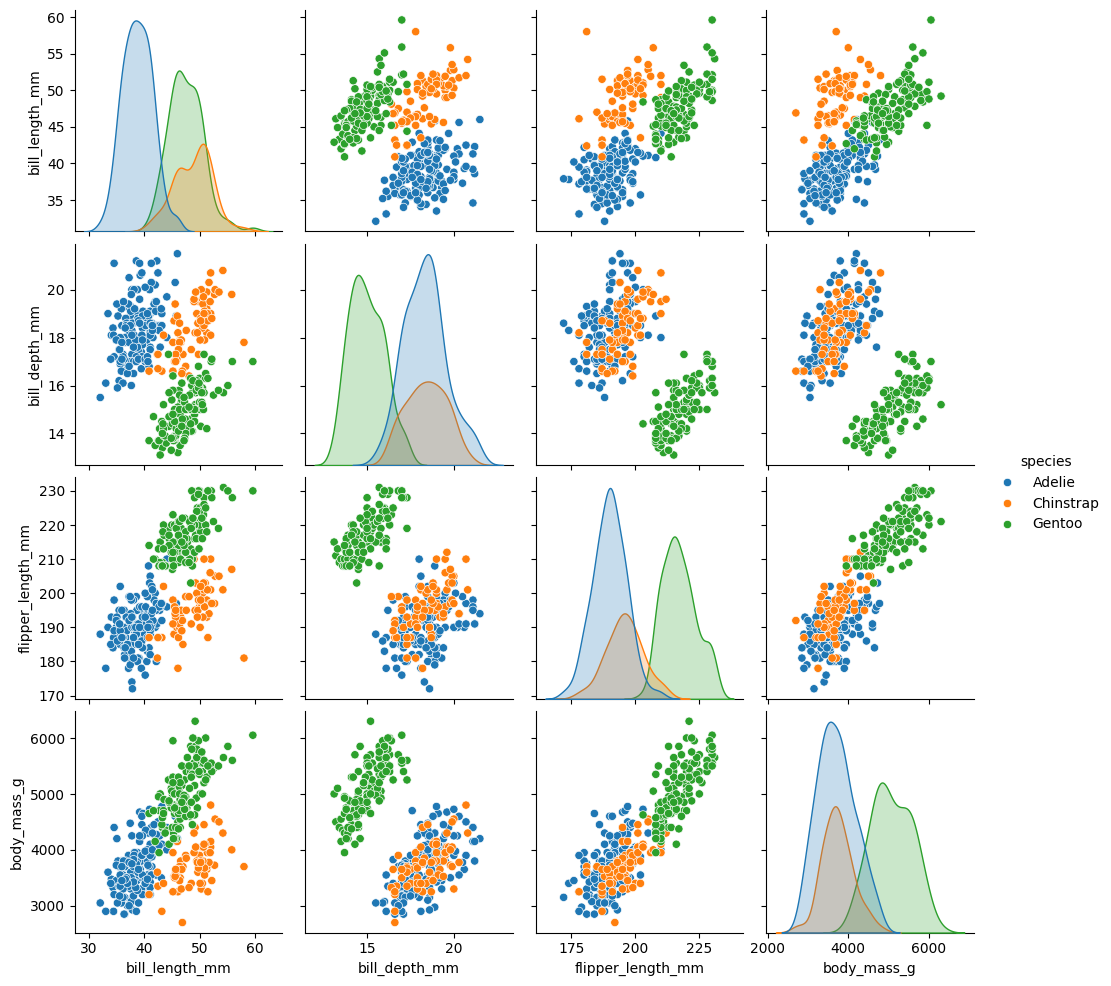

In [15]:
# 4-1 종(species)별 특성 간 산점도 매트릭스 표시 (.pairplot() 메소드)
sns.pairplot(penguins, hue='species')
plt.show()

### 문제 5) 머신러닝 모델 구축 및 성능 평가

In [16]:
# 5-1 훈련데이터, 테스터데이터 분할
x = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins['species']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
# 5-2 결정 트리(DecisionTreeClassifier) 모델 생성 및 학습
model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [18]:
# 5-3 모델을 이용한 예측 수행
y_pred = model.predict(x_test)

In [19]:
# 5-4 모델 성능 평가 수행
print(f'정확도 : {accuracy_score(y_test, y_pred)}')
print(f'분류 리포트:\n {classification_report(y_test, y_pred)}')

정확도 : 0.9855072463768116
분류 리포트:
               precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        32
   Chinstrap       0.94      1.00      0.97        16
      Gentoo       1.00      0.95      0.98        21

    accuracy                           0.99        69
   macro avg       0.98      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69

